In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [2]:
pwd

'/Users/mac/OneDrive - University of Massachusetts Dartmouth/Fall_2021/DataViz_DSC_530/Lectures_Fall_2021/Week 13/myEyeTribe'

In [3]:
 
with open("minard.txt",'r')as data:
    results = data.read()

In [4]:
results=results.split('\n')

In [5]:
data_json = []
for row in results:
    try:
        data_json.append(json.loads(row)['values']['frame'])
    except Exception as ex:
        pass
        #print(row)
    

In [6]:
data_json[0]

{'avg': {'x': 262.3307, 'y': 848.7802},
 'fix': True,
 'lefteye': {'avg': {'x': 204.2929, 'y': 854.2543},
  'pcenter': {'x': 0.2929, 'y': 0.4058},
  'psize': 14.1814,
  'raw': {'x': 203.9221, 'y': 868.2102}},
 'raw': {'x': 258.7679, 'y': 870.1525},
 'righteye': {'avg': {'x': 303.7527, 'y': 859.0447},
  'pcenter': {'x': 0.4864, 'y': 0.4234},
  'psize': 13.8861,
  'raw': {'x': 313.6137, 'y': 872.0947}},
 'state': 7,
 'time': 384696523,
 'timestamp': '2020-11-29 21:14:25.227'}

In [7]:
#https://theeyetribe.com/dev.theeyetribe.com/dev.theeyetribe.com/api/index.html
data_final = []
for row in data_json:
    data_final.append({'timestamp' : row['timestamp'],
                      'Fixation':row['fix'],
                       'left_x' : row['lefteye']['avg']['x'],
                       'left_y' : row['lefteye']['avg']['y'],
                       'left_pupil_diameter' : np.sqrt(row['lefteye']['psize']/np.pi)*2,
                       'right_x' : row['righteye']['avg']['x'],
                       'right_y' : row['righteye']['avg']['y'],
                       'right_pupil_diameter' : np.sqrt(row['righteye']['psize']/np.pi)*2
                      })

In [8]:
df=pd.DataFrame(data_final)
df['timestamp']=pd.to_datetime(df['timestamp'])

In [9]:
df.head()

,timestamp,Fixation,left_x,left_y,left_pupil_diameter,right_x,right_y,right_pupil_diameter
0,2020-11-29 21:14:25.227,True,204.2929,854.2543,4.249273,303.7527,859.0447,4.204799
1,2020-11-29 21:14:25.260,True,204.6348,854.2934,4.163444,304.6197,860.4651,4.164239
2,2020-11-29 21:14:25.293,True,205.1821,854.1089,4.198905,305.3882,859.2324,4.071338
3,2020-11-29 21:14:25.327,True,205.5424,853.9716,4.187868,305.8320,858.0418,4.134628
4,2020-11-29 21:14:25.360,True,205.3209,854.9476,4.158410,307.5676,859.0733,4.141951


In [10]:
## aggregate fixations

In [11]:
previous_state = True
fixation_blobs = []
saccade_blobs = []
temp_fixation =[]
temp_saccades =[]
for i,row in enumerate(data_final):
    if (previous_state == True) and (row['Fixation']== True):
        ## fixation continues
        temp_fixation.append(i)
    elif (previous_state == True) and (row['Fixation']== False):
        ## fixation ended
        previous_state= False
        if len(temp_fixation)>0:
            fixation_blobs.append(temp_fixation.copy())
        temp_fixation = []
        temp_saccades.append(i)
    elif (previous_state == False) and (row['Fixation']== True):
        ## fixation started
        previous_state = True        
        temp_fixation.append(i)
        if len(temp_saccades)>0:
            saccade_blobs.append(temp_saccades.copy())
        temp_saccades = []
    else:
        ## Saccade continues
        temp_saccades.append(i)

In [12]:
lst_fixations = []
for fixation in fixation_blobs:
    df_fx = df[df.index.isin(fixation)].copy()
    c=(df_fx.iloc[-1]['timestamp'] - df_fx.iloc[0]['timestamp']).total_seconds()*1000
    lst_fixations.append({'time':df_fx.iloc[0]['timestamp'],
                          'duration':c,
                          'x':df_fx['left_x'].mean(),
                          'y':df_fx['left_y'].mean(),
                          'pupil_diameter':df_fx['left_pupil_diameter'].mean()})
    

In [13]:
df_fixation_final = pd.DataFrame(lst_fixations)

In [14]:
df_fixation_final.head()

,time,duration,x,y,pupil_diameter
0,2020-11-29 21:14:25.227,932.0,289.517331,726.791745,4.221305
1,2020-11-29 21:14:26.393,332.0,349.112609,683.999018,4.368303
2,2020-11-29 21:14:27.359,1032.0,644.308878,477.538575,4.417101
3,2020-11-29 21:14:28.824,400.0,1303.702815,477.693715,4.300508
4,2020-11-29 21:14:30.057,133.0,1193.071180,787.245860,4.194928


In [15]:
df_fixation_final.to_csv('fixations.csv',index=None)

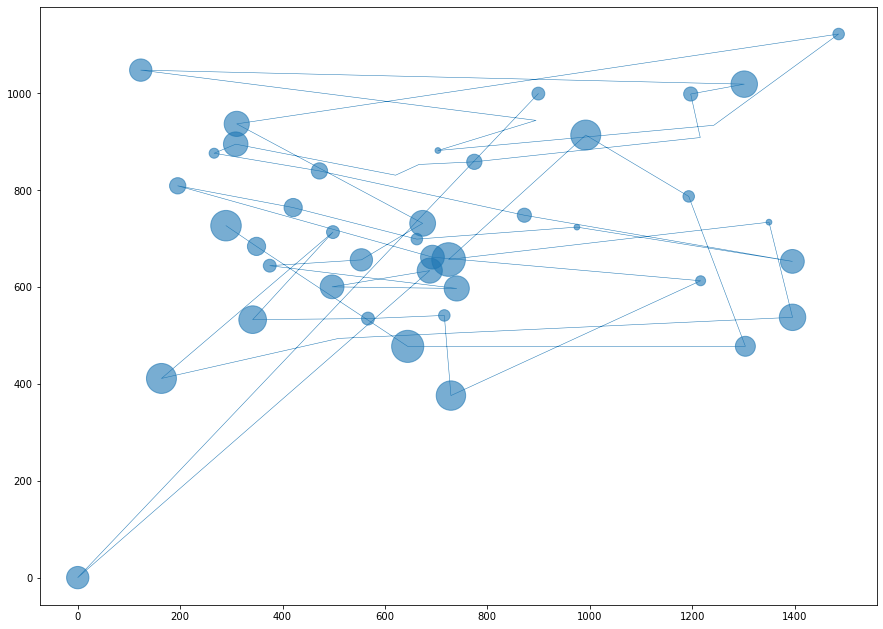

In [26]:
f,ax = plt.subplots(1,1,figsize=(15,11))
plt.scatter(df_fixation_final['x'],df_fixation_final['y'],s=df_fixation_final['duration'],alpha=.6)
plt.plot(df_fixation_final['x'],df_fixation_final['y'],lw=.5)